##### Aim of this notebook

The goal of mass spectrometry is to identify molecules by measuring their mass to charge ratios.
Information is extracted by fitting gaussian to the data at the peak (to stay away from underlying background).
Low statistics at the peak often tempt to interpolate data prior to fitting. Interpolation requires some sort of noise removal which is often achieved by smoothing. Smoothing + interoplation is good for visualization but 
does not have any proven advantage. In contraty, it is computationally expensive, may affect real data in intricate ways and at best will not provide any bias. 
Another topic is testing weather the peak was gaussian. By smoothing + interpolating one diminishes residuals of the fit but does not improve possibility to test weather data follow gaussian distribution or not. There are several measures to test goodness_of-fit, e.g. chi2 over degrees of freedom.

In this notebook, MC technique is used to demonstrate impact of smoothing+interpolating.
We start by simulating an equidistant grid of random points which follow a true gaussian. Add random noise to the data. Fit data, extract mean, width, chi2 and residuals squarred. Then smooth, interpolate and fit again. The first time we plot data at each step to see how the distrubution changes. Then we run this procedure 10000 times to see the fit values in both cases. As shown, fitted mean and width are at the same level, so smoothing + interpolating has not helped parameter estimation, but the procedure lowered the residuals (but it does not mean that our original data are more gaussian!). Chi2/dof at the level of 1.5 (fit to original data) confirms that data follow gaussian as expected.

In [1]:
using Plots
using LsqFit
using Distributions
using Statistics
using Dierckx # interpolation

##### Define a true gaussian and plot it

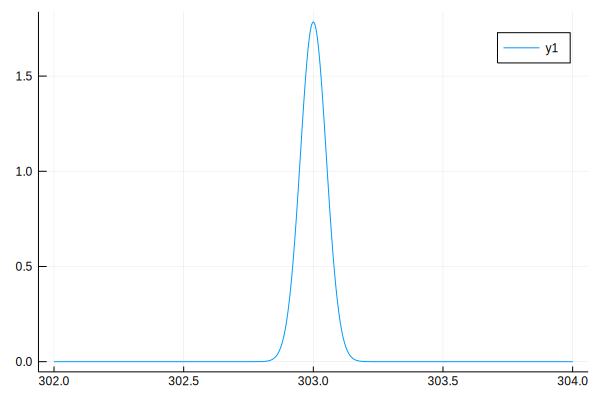

In [2]:
mean= 303.0
sigma = 0.05

function gauss(xdata, mean, sigma)
    return 1/sqrt(2*pi*sigma)*exp(-(xdata-mean)^2/2sigma^2)
end

xdata = collect(302:0.002:304)
ydata = gauss.(xdata, mean, sigma)
plot(xdata, ydata)

##### Define smoothing and interpolating functions

In [3]:
function smooth(y, n)
    # Rolling average used in Feature Detection
    w = convert(Int64,(n-1)/2)
    vals = zeros(size(y,1))
    for i=2:size(vals,1)-w
        tv1 =y[i-w:i+w]
        vals[i] =Statistics.mean(tv1)
    end
    vals[1] =y[1]
    vals[end]=y[end]
    return vals
end

function interpolate(xdata, ydata)
    # Spline interpolation used in feature detection
    spl=Spline1D(xdata, ydata; k=3, bc="nearest", s=0.0)
    xdata_int=range(minimum(xdata),stop=maximum(xdata),length=50)
    ydata_int=spl(xdata_int)
    ydata_out=ydata_int[ydata_int.>=maximum(ydata)/2]
    xdata_out=xdata_int[ydata_int.>=maximum(ydata)/2]
    return xdata_out, ydata_out
end


interpolate (generic function with 1 method)

##### Sample true gaussian on equidistant grid

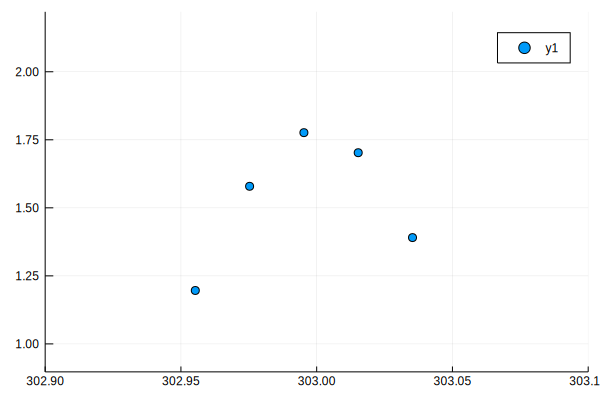

In [4]:
number_of_point = 5
bin_width = 0.02
# We cannot draw from flat distribution because we know that grid is equidistant.
# Instead we can draw phase shift within half bin width for entire grid
xdata = collect(mean-2*bin_width:bin_width: mean+2*bin_width) + 0.5*bin_width*(rand()-0.5)*ones(number_of_point)
# xdata = mean*ones(number_of_point)+2*sigma*(rand(number_of_point)- 0.5*ones(number_of_point))
sort!(xdata)
ydata = gauss.(xdata, mean, sigma)
# plot data points
xrange = (mean - 2*sigma , mean + 2*sigma)
yrange = (0.75*minimum(ydata), 1.25*maximum(ydata))
scatter(xdata, ydata, xlim = xrange, ylim = yrange)


##### Add noise (5% of max y - value) and plot

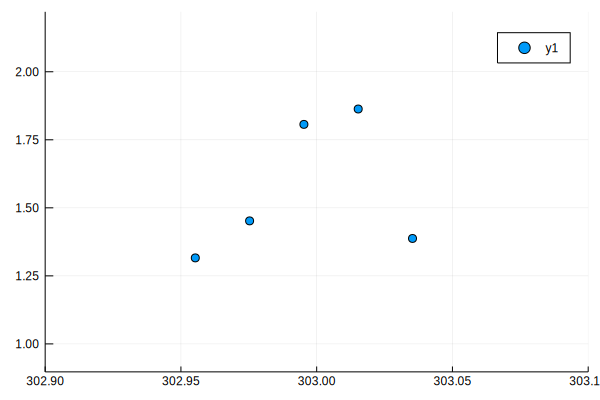

In [5]:
mean_noise = 0
sigma_noise = 0.05*maximum(ydata) # 5%
noise = rand(Normal(mean_noise, sigma_noise), number_of_point)
ydata_noise = ydata + noise
scatter(xdata, ydata_noise, xlim = xrange, ylim = yrange)

##### Fit data with noise

In [6]:
@.model(x, p) = (1/(p[2]*sqrt(pi*2))) * exp(-(x-p[1])^2 / (2*p[2]^2))
p0 = [Statistics.mean(xdata),Statistics.std(xdata)]
fit = curve_fit(model, xdata, ydata_noise, p0)
mean_est = coef(fit)[1]
r = fit.resid
std_est = coef(fit)[2]
dof_fit = dof(fit)
println("Esimated mean+/- sigma: ", mean_est, "+/-", std_est)
println("Residual: ", sum(r.*r))
println("Degrees of freedom: ", dof_fit)
ydata_est = gauss.(xdata, mean_est, std_est)
chi2 = sum((ydata_noise - ydata_est).*(ydata_noise - ydata_est)./ydata_est)
println("chi2/dof: ", chi2/dof_fit)
println("r2/nbin: ", sum(r.*r)/length(xdata))

Esimated mean+/- sigma: 303.09066413549+/-0.2324748017624947
Residual: 0.20821135448558997
Degrees of freedom: 3
chi2/dof: 1.5325692199618006
r2/nbin: 0.04164227089711799


#### Smooth data and plot

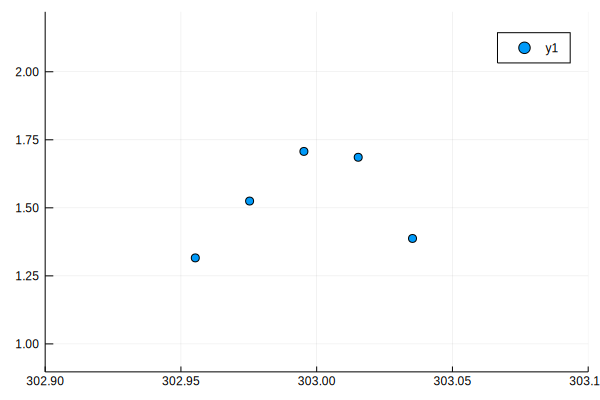

In [7]:
ydata_smooth = smooth(ydata_noise, 3)
scatter(xdata, ydata_smooth, xlim = xrange, ylim = yrange)

##### Interpolate with spline and plot

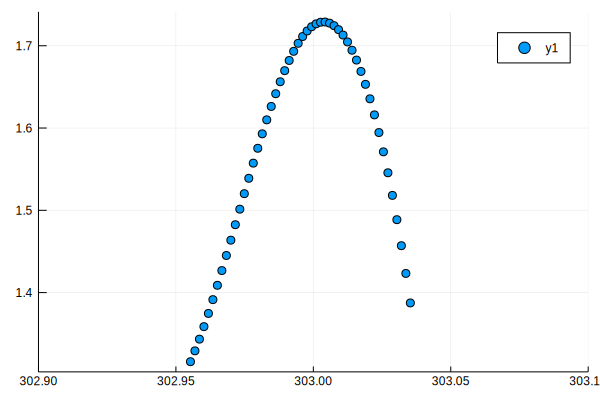

In [8]:
xdata_int, ydata_int = interpolate(xdata, ydata_smooth)
scatter(xdata_int, ydata_int, xlim = xrange)

##### Fit interpolated data

In [9]:
p0 = [Statistics.mean(xdata),Statistics.std(xdata)]
fit = curve_fit(model, xdata_int, ydata_int, p0)
mean_est = coef(fit)[1]
r = fit.resid
std_est = coef(fit)[2]
dof_fit = dof(fit)
println("Esimated mean+/- sigma: ", mean_est, "+/-", std_est)
println("Residual: ", sum(r.*r))
println("Degrees of freedom: ", dof_fit)
ydata_est = gauss.(xdata, mean_est, std_est)
# chi2 = sum((ydata_noise - ydata_est).*(ydata_noise - ydata_est)./ydata_est)
println("r2/nbin: ", sum(r.*r)/length(xdata_int))

Esimated mean+/- sigma: 303.0817684746462+/-0.23551380148397366
Residual: 0.5941375674398625
Degrees of freedom: 48
r2/nbin: 0.011882751348797248


##### MC simulate fitting noisy data

In [12]:
niter= 10000
eval_mean = zeros(niter)
eval_std = zeros(niter)
fit_chi2 = zeros(niter)
for inx in eachindex(eval_mean)
    ## simulate measurement points
    xdata = collect(mean-2*bin_width:bin_width: mean+2*bin_width) + 0.5*bin_width*(rand()-0.5)*ones(number_of_point)
    ydata = gauss.(xdata, mean, sigma)
    ## add noise
    mean_noise = 0
    sigma_noise = 0.05*maximum(ydata) # 5%
    noise = rand(Normal(mean_noise, sigma_noise), number_of_point)
    ydata = ydata + noise
    p0 = [Statistics.mean(xdata),Statistics.std(xdata)]
    fit = curve_fit(model, xdata, ydata, p0)
    eval_mean[inx] = coef(fit)[1]
    eval_std[inx] = coef(fit)[2]
    ydata_est = gauss.(xdata,coef(fit)[1] ,coef(fit)[2])
    chi2 = sum((ydata - ydata_est).*(ydata - ydata_est)./ydata_est)
    fit_chi2[inx] = chi2/dof(fit)
end

println("Mean: ",Statistics.mean(eval_mean), " std ", Statistics.std(eval_mean))
println("Mean chi2: ",Statistics.mean(fit_chi2), " std ", Statistics.std(fit_chi2))

Mean: 303.0008340569239 std 0.07132277444004537
Mean chi2: 1.3954615178419472 std 0.134480286135901


##### MC simulate fitting smoothed and interpolated data

In [13]:
niter= 10000
eval_mean = zeros(niter)
eval_std = zeros(niter)
fit_r2 = zeros(niter)
for inx in eachindex(eval_mean)
    ## simulate measurement points
    xdata = collect(mean-2*bin_width:bin_width: mean+2*bin_width) + 0.5*bin_width*(rand()-0.5)*ones(number_of_point)
    ydata = gauss.(xdata, mean, sigma)
    ## add noise
    mean_noise = 0
    sigma_noise = 0.05*maximum(ydata) # 5%
    noise = rand(Normal(mean_noise, sigma_noise), number_of_point)
    ydata = ydata + noise
    ## smooth
    ydata_smooth = smooth(ydata, 3)
    ## interpolate
    xdata_int, ydata_int = interpolate(xdata, ydata_smooth)
    xdata = xdata_int
    ydata = ydata_int
    p0 = [Statistics.mean(xdata),Statistics.std(xdata)]
    fit = curve_fit(model, xdata, ydata, p0)
    eval_mean[inx] = coef(fit)[1]
    eval_std[inx] = coef(fit)[2]
    r = fit.resid
    fit_r2[inx] = sum(r.*r)/length(xdata)
end

println("Mean: ",Statistics.mean(eval_mean), " std ", Statistics.std(eval_mean))
println("Mean r2: ",Statistics.mean(fit_r2), " std ", Statistics.std(fit_r2))

Mean: 302.9995297786461 std 0.07019771186036924
Mean r2: 0.014930115827769702 std 0.006239804991574947
